<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#FX-Carry" data-toc-modified-id="FX-Carry-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>FX Carry</a></span></li><li><span><a href="#Performance" data-toc-modified-id="Performance-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Performance</a></span><ul class="toc-item"><li><span><a href="#Run-backtest" data-toc-modified-id="Run-backtest-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Run backtest</a></span></li><li><span><a href="#Recent-performance" data-toc-modified-id="Recent-performance-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Recent performance</a></span></li></ul></li><li><span><a href="#Reference" data-toc-modified-id="Reference-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Reference</a></span></li></ul></div>

# FX Carry

This notebook analyses the FX carry trade (aka forward premium anomaly) where we long high-yielding currencies against low-yielding ones. The uncovered interest rate parity (UIP) suggests that higher-yielding currencies should depreciate on average to offset the benefit of higher interest rates. Empirically however that those currencies tended to weaken much less (or even appreciate) than what the UIP predicts. The FX carry strategy tries to exploit this phenomenon by creating a long-short portfolio in the FX market.

In [1]:
%matplotlib inline
from datetime import datetime
import logging
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('bmh')

from vivace.backtest import signal
from vivace.backtest import processing
from vivace.backtest.engine import BacktestEngine
from vivace.backtest.enums import Strategy, Weighting
from vivace.backtest.stats import Performance, PerfStats

# Performance
## Run backtest

The `engine` instance below implements a FX carry backtest using FX futures listed on CME. Currencies used in the backtest are EUR, JPY, GBP, CAD, AUD and NZD. Carry is defined as
$$
Carry_t = \frac{F_{1, t} - F_{2, t}}{annualisationFactor}
$$
where $F_{1, t}$ is the 1st contract price, $F_{2, t}$ is the 2nd contract price and $annualisationFactor$ is 12 or 4 if futures are monthly or quarterly respectively to make the price spread annual.

The backtest always invests in the front contract and hence the formula above is not technically measuring the carry associated with invested contracts. On the other hand, this can alleviate the issue of potentially using asynchronous prices (settle prices are used to calculate carry) and as long as futures curve is close to linear, it should provide a gooe measure of carry.

In [2]:
engine = BacktestEngine(
    strategy=Strategy.DELTA_ONE.value,
    instrument=['EC', 'JY', 'BP', 'CD', 'AD', 'ZB'],
    signal=signal.XSCarryFutureFuture(),
    log_level=logging.WARN,
)
engine.run()

In [3]:
portfolio_return = (engine.calculate_equity_curve(calculate_net=False)
                    .rename('FX carry portfoliot'))

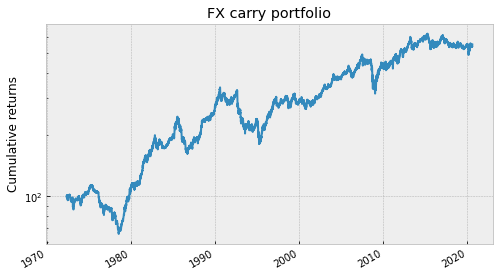

In [4]:
fig, ax = plt.subplots(figsize=(8, 4.5))
portfolio_return.plot(ax=ax, logy=True);
ax.set_title('FX carry portfolio')
ax.set_ylabel('Cumulative returns');

In [5]:
portfolio_return.pipe(Performance).summary()

,FX carry portfoliot
annualised return,0.041164
annualised vol,0.109273
Sharpe ratio,0.376704
max drawdown,0.470048
Calmar ratio,0.087573
skewness,-0.464787
kurtosis,7.527768
worst return,-0.091076
worst 1d return,-0.091076
worst 1w return,-0.114315


## Recent performance

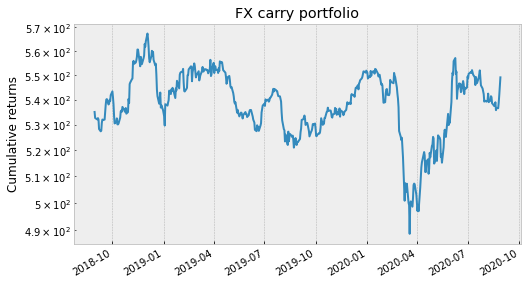

In [6]:
fig, ax = plt.subplots(figsize=(8, 4.5))
portfolio_return.tail(252 * 2).plot(ax=ax, logy=True);
ax.set_title('FX carry portfolio')
ax.set_ylabel('Cumulative returns');

# Reference

- Deutsche Bank, 2009, db Currency Return.
- Koijen, R.S., Moskowitz, T.J., Pedersen, L.H. and Vrugt, E.B., 2018. Carry. Journal of Financial Economics, 127(2), pp.197-225.

In [7]:
print(f'Updated: {datetime.utcnow().strftime("%d-%b-%Y %H:%M")}')

Updated: 31-Aug-2020 07:38
